In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 200)

In [4]:
FOLDER = '~/[2021-01] Data Scientist IC Takehome/'
DELTA_T = 8
BINS = [0, 1, 2, 7]
LABELS = ['day_0', 'day_1', 'day_2+']
DATE_PARSER = lambda l: pd.to_datetime([val[:-4] for val in l])

# Registrations & Active Day Usage

In [5]:
reg = pd.read_csv(f'{FOLDER}registrations.csv',
                  parse_dates=['hour_pt'],
                  date_parser=DATE_PARSER,
                  usecols=['user_id', 'hour_pt', 'platform']) \
    .rename(columns={'platform': 'registration_platform'})
reg['registration_day_pt'] = pd.to_datetime(reg.hour_pt.map(lambda s: str(s)[:10]))
reg['registration_dow_pt'] = reg.registration_day_pt.dt.strftime('%a')
reg['is_weekend_registration'] = reg.registration_dow_pt.isin(['Sat', 'Sun'])

In [33]:
def clean_df(df, dropna=True):
    if 'active_day_pt' not in df.columns:
        df['hour_pt'] = df.hour_pt.map(lambda s: s[:-4]).map(pd.to_datetime)
        df['active_day_pt'] = pd.to_datetime(df.hour_pt.map(lambda s: str(s)[:10]))
    df = pd.merge(reg[['user_id', 'registration_day_pt']], df, on='user_id')
    df['day_number'] = (df.active_day_pt - df.registration_day_pt).dt.days
    df['day_category'] = pd.cut(df.day_number, bins=BINS, labels=LABELS, include_lowest=True)
    if not dropna:
        return df
    return df[~df.day_category.isna()]

In [34]:
active_day_usage = pd.merge(pd.read_csv(f'{FOLDER}active_day.csv'), 
                            pd.read_csv(f'{FOLDER}platform_usage_day.csv'), 
                            on=['user_id', 'day_pt'], 
                            how='outer')
active_day_usage['active_day_pt'] = active_day_usage.day_pt.map(lambda s: s[:-4]).map(pd.to_datetime)
active_day_usage = clean_df(active_day_usage, dropna=False)

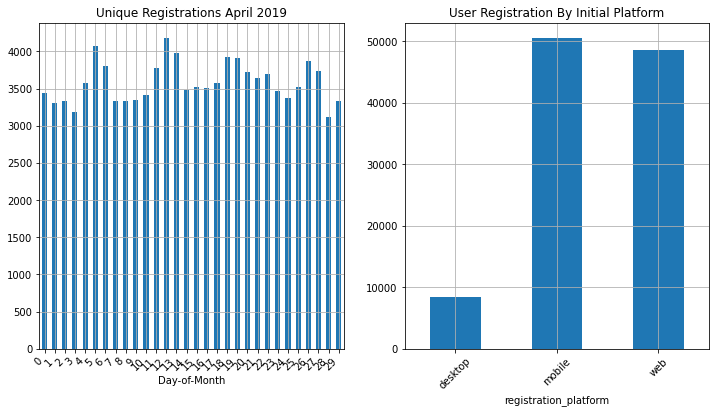

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False);
reg.set_index('hour_pt').resample('1D')['user_id'].nunique().plot(kind='bar', grid=True, ax=ax1);
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'));
ax1.set_xlabel('Day-of-Month');
ax1.set_title('Unique Registrations April 2019');
ax1.set_xticklabels(ax1.get_xticks(), rotation=45, ha='right');

reg.groupby('registration_platform')['user_id'].nunique().plot(grid=True, kind='bar', ax=ax2);
ax2.set_title('User Registration By Initial Platform');
ax2.tick_params(axis='x', labelrotation = 45)

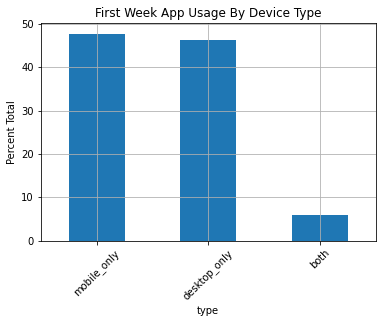

In [36]:
f, ax = plt.subplots()
tmp = active_day_usage.set_index('user_id').loc[:, 'used_mobile':'used_desktop_any'].reset_index().groupby(
    'user_id').any().value_counts(normalize=True).mul(100).round(
    2).reset_index().rename(columns={0: 'perc_total'})
tmp['type'] = ['mobile_only', 'desktop_only', 'both']
tmp.set_index('type')['perc_total'].plot(kind='bar', grid=True, ax=ax);
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Percent Total');
ax.set_title('First Week App Usage By Device Type');

# Exploratory Data Analysis

In [37]:
eda = pd.merge(reg[['user_id', 'registration_day_pt', 'registration_dow_pt', 'is_weekend_registration', 'registration_platform']], 
               active_day_usage[['user_id', 'active_day_pt']], 
               on='user_id',
               how='left')
eda['days_active'] = eda.groupby('user_id')['active_day_pt'].transform('nunique')
eda['day_number'] = (eda.active_day_pt - eda.registration_day_pt).dt.days
eda['min_day_number'] = eda.groupby('user_id').day_number.transform(min)
eda['max_day_number'] = eda.groupby('user_id').day_number.transform(max)
eda['first_active_day_pt'] = eda.groupby('user_id')['active_day_pt'].transform(min)
eda['is_retained'] = eda.max_day_number >= DELTA_T
eda['is_bounce_0'] = eda.max_day_number == 0

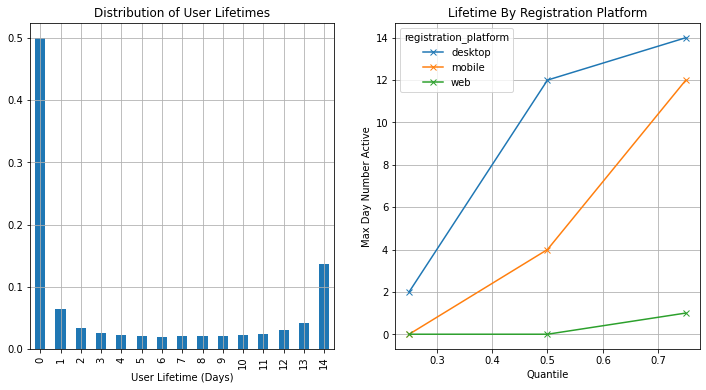

In [38]:
# Distribution of Customer Lifetimes
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6));
eda[['user_id', 'max_day_number']].drop_duplicates().max_day_number.value_counts(normalize=True).sort_index().plot(kind='bar', grid=True, ax=ax1);
ax1.set_title('Distribution of User Lifetimes');
ax1.set_xlabel('User Lifetime (Days)')

# Max Day Active By Registration Platform
eda.drop_duplicates(subset=['user_id', 'registration_platform'])\
.groupby('registration_platform').max_day_number.quantile([0.25, 0.50, 0.75]).unstack().T.plot(grid=True, marker='x', ax=ax2);
ax2.set_ylabel('Max Day Number Active');
ax2.set_xlabel('Quantile');
ax2.set_title('Lifetime By Registration Platform');

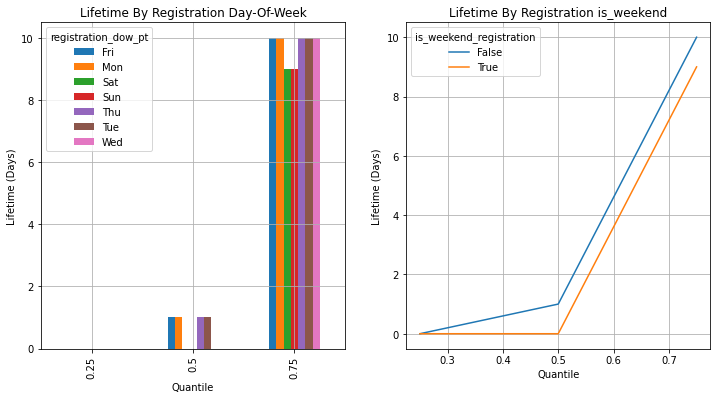

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6));
eda.drop_duplicates(subset=['user_id', 'registration_dow_pt'])\
.groupby('registration_dow_pt').max_day_number.quantile([0.25, 0.50, 0.75]).unstack().T.plot(kind='bar', grid=True, ax=ax1);
ax1.set_ylabel('Lifetime (Days)');
ax1.set_xlabel('Quantile');
ax1.set_title('Lifetime By Registration Day-Of-Week');

eda.drop_duplicates(subset=['user_id', 'is_weekend_registration'])\
.groupby('is_weekend_registration').max_day_number.quantile([0.25, 0.50, 0.75]).unstack().T.plot(grid=True, ax=ax2);
ax2.set_ylabel('Lifetime (Days)');
ax2.set_xlabel('Quantile');
ax2.set_title('Lifetime By Registration is_weekend');

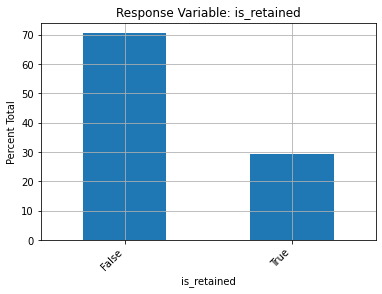

In [40]:
# Percentage of users who are active any time during their second week
eda[['user_id', 'is_retained']].drop_duplicates().is_retained.value_counts(normalize=True).mul(100).round(2).plot(kind='bar', stacked=True, grid=True);
plt.title('Response Variable: is_retained');
plt.ylabel('Percent Total');
plt.xlabel('is_retained');
plt.xticks(rotation=45, ha='right');

In [41]:
# Percentage of users who bounce the first day
eda[['user_id', 'is_bounce_0']].drop_duplicates().is_bounce_0.value_counts(normalize=True).mul(100).round(2)

False    50.12
True     49.88
Name: is_bounce_0, dtype: float64

In [42]:
# Add Friend
af = clean_df(pd.read_csv(f'{FOLDER}add_friend.csv'))
af_2 = af.groupby(['user_id', 'status', 'day_category'])['other_user_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
af_2.columns = [tup[1].replace('day', tup[0]) for tup in af_2.columns.values]
af_3 = af.groupby(['user_id', 'status'])['other_user_id'].size().unstack(level=1).replace({np.NaN: 0})
af_3.columns = [f'{col}_total' for col in af_3.columns]
af_4 = af_2.join(af_3)
af_4.sample()

,received_friend_request_0,received_friend_request_1,received_friend_request_2+,sent_friend_request_0,sent_friend_request_1,sent_friend_request_2+,successfully_added_friend_0,successfully_added_friend_1,successfully_added_friend_2+,received_friend_request_total,sent_friend_request_total,successfully_added_friend_total
user_id,,,,,,,,,,,,
568785244472225903,1,0,0,0,0,0,1,0,0,1.0,0.0,1.0


In [43]:
# Join Server
js = clean_df(pd.read_csv(f'{FOLDER}join_server.csv'))
js['log_server_size'] = js.size_at_join.map(np.log)
js['server_status'] = pd.cut(js.log_server_size, bins=3, labels=['small', 'medium', 'large'])
js_2 = js.groupby(['user_id', 'server_status', 'day_category'])['server_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
js_2.columns = [tup[1].replace('day', tup[0]) for tup in js_2.columns.values]
js_3 = js.groupby(['user_id', 'server_status'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
js_3.columns = [f'{col}_total' for col in js_3.columns]
js_3['join_total'] = js_3.sum(axis=1)
js_4 = js_2.join(js_3)
js_4.sample()

,small_0,small_1,small_2+,medium_0,medium_1,medium_2+,large_0,large_1,large_2+,small_total,medium_total,large_total,join_total
user_id,,,,,,,,,,,,,
565871691860029700,0,0,0,1,0,0,4,0,0,0,1,4,5


In [44]:
# Create Server
cs = clean_df(pd.read_csv(f'{FOLDER}create_server.csv'))
cs_2 = cs.groupby(['user_id', 'day_category'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
cs_2.columns = [f'create_{col}' for col in cs_2.columns]
cs_3 = cs.groupby(['user_id'])['server_id'].size().to_frame('create_total')
cs_4 = cs_2.join(cs_3)
cs_4.sample()

,create_day_0,create_day_1,create_day_2+,create_total
user_id,,,,
563481936916525065,1,0,0,1


In [45]:
# Send Message
sm = clean_df(pd.read_csv(f'{FOLDER}send_message.csv'))
sm_2 = sm.groupby(['user_id', 'channel_type', 'day_category'])['server_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
sm_2.columns = ['send_' + tup[1].replace('day', tup[0]) for tup in sm_2.columns.values]
sm_3 = sm.groupby(['user_id', 'channel_type'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
sm_3.columns = [f'send_{col}_total' for col in sm_3.columns]
sm_3['send_total'] = sm_3.sum(axis=1)
sm_4 = sm_2.join(sm_3)
sm_4.sample()

,send_direct_message_0,send_direct_message_1,send_direct_message_2+,send_group_direct_message_0,send_group_direct_message_1,send_group_direct_message_2+,send_server_channel_0,send_server_channel_1,send_server_channel_2+,send_direct_message_total,send_group_direct_message_total,send_server_channel_total,send_total
user_id,,,,,,,,,,,,,
570949011360591978,1,0,0,0,0,0,1,0,0,1.0,0.0,1.0,2.0


In [46]:
# Read Message
rm = clean_df(pd.read_csv(f'{FOLDER}read_message.csv'))
rm_2 = rm.groupby(['user_id', 'channel_type', 'day_category'])['server_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
rm_2.columns = ['read_' + tup[1].replace('day', tup[0]) for tup in rm_2.columns.values]
rm_3 = rm.groupby(['user_id', 'channel_type'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
rm_3.columns = [f'read_{col}_total' for col in rm_3.columns]
rm_3['read_total'] = rm_3.sum(axis=1)
rm_4 = rm_2.join(rm_3)
rm_4.sample()

,read_direct_message_0,read_direct_message_1,read_direct_message_2+,read_group_direct_message_0,read_group_direct_message_1,read_group_direct_message_2+,read_server_channel_0,read_server_channel_1,read_server_channel_2+,read_direct_message_total,read_group_direct_message_total,read_server_channel_total,read_total
user_id,,,,,,,,,,,,,
570210525225693307,1,0,0,0,0,0,3,0,0,1.0,0.0,3.0,4.0


In [47]:
# Start Speaking
ss = clean_df(pd.read_csv(f'{FOLDER}start_speaking.csv'))
ss_2 = ss.groupby(['user_id', 'channel_type', 'day_category'])['server_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
ss_2.columns = ['speak_' + tup[1].replace('day', tup[0]) for tup in ss_2.columns.values]
ss_3 = ss.groupby(['user_id', 'channel_type'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
ss_3.columns = [f'speak_{col}_total' for col in ss_3.columns]
ss_3['speak_total'] = ss_3.sum(axis=1)
ss_4 = ss_2.join(ss_3)
ss_4.sample()

,speak_direct_message_0,speak_direct_message_1,speak_direct_message_2+,speak_group_direct_message_0,speak_group_direct_message_1,speak_group_direct_message_2+,speak_server_channel_0,speak_server_channel_1,speak_server_channel_2+,speak_direct_message_total,speak_group_direct_message_total,speak_server_channel_total,speak_total
user_id,,,,,,,,,,,,,
568456946810761288,0,0,0,0,0,0,8,0,0,0.0,0.0,8.0,8.0


In [48]:
# Start Listening
sl = clean_df(pd.read_csv(f'{FOLDER}start_listening.csv'))
sl_2 = sl.groupby(['user_id', 'channel_type', 'day_category'])['server_id'].size().unstack(level=1).unstack(level=1).replace({np.NaN: 0})
sl_2.columns = ['listen_' + tup[1].replace('day', tup[0]) for tup in sl_2.columns.values]
sl_3 = sl.groupby(['user_id', 'channel_type'])['server_id'].size().unstack(level=1).replace({np.NaN: 0})
sl_3.columns = [f'listen_{col}_total' for col in sl_3.columns]
sl_3['listen_total'] = sl_3.sum(axis=1)
sl_4 = sl_2.join(sl_3)
sl_4.sample()

,listen_direct_message_0,listen_direct_message_1,listen_direct_message_2+,listen_group_direct_message_0,listen_group_direct_message_1,listen_group_direct_message_2+,listen_server_channel_0,listen_server_channel_1,listen_server_channel_2+,listen_direct_message_total,listen_group_direct_message_total,listen_server_channel_total,listen_total
user_id,,,,,,,,,,,,,
570679166761054301,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,1.0


In [49]:
dat = eda[['user_id', 'is_retained', 'is_weekend_registration', 'registration_platform']].drop_duplicates().set_index('user_id')\
.join(af_4, how='left').join(js_4, how='left').join(cs_4, how='left').join(sm_4, how='left').join(rm_4, how='left').join(ss_4, how='left').join(sl_4, how='left').fillna(0)

# Build ML Model to Predict User Retention

In [50]:
y = dat[['is_retained']].astype(int)
X = pd.get_dummies(dat.loc[:, 'is_weekend_registration':])

In [51]:
colz_to_use = [col for col in X.columns if '_2+' not in col 
               and 'total' not in col 
               and '_1' not in col 
               and 'registration' not in col]

X_train, X_test, y_train, y_test = train_test_split(X[colz_to_use].astype(bool), 
                                                    y.is_retained)

In [52]:
X_train.iloc[:5, :5]

,received_friend_request_0,sent_friend_request_0,successfully_added_friend_0,small_0,medium_0
user_id,,,,,
567214200003506214,False,False,False,False,True
572745793476505701,False,False,False,False,False
570923280253464698,False,False,False,False,False
567120344951959599,False,False,False,False,False
572127751851487275,True,False,True,False,False


In [53]:
y.value_counts(normalize=True)

is_retained
0              0.70636
1              0.29364
dtype: float64

In [54]:
scale_pos_weight = len(y[y.is_retained == 0]) / len(y[y.is_retained == 1])
model = XGBClassifier(learning_rate = 0.1, 
                      max_depth=5, 
                      objective='binary:logistic', 
                      subsample=0.75, 
                      scale_pos_weight=scale_pos_weight, 
                      use_label_encoder=False);

In [55]:
model.fit(X_train, y_train)

[14:44:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.405534774614848,
              subsample=0.75, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
res = y_test.to_frame()
res.columns = ['y_true']
res['y_pred'] = model.predict(X_test)
res['y_prob'] = model.predict_proba(X_test)[:, 1]

In [57]:
thresh = []
acc = []

for t in np.linspace(0.01, 0.99, 100):
    thresh.append(t)
    tmp = res.copy()
    tmp['y_pred'] = (tmp['y_prob'] >= t).astype(int)
    a = (tmp.y_pred == tmp.y_true).sum() / len(tmp)
    acc.append(a)

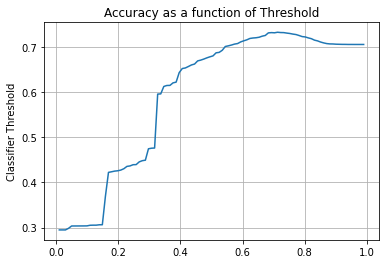

In [58]:
plt.plot(thresh, acc);
plt.grid();
plt.title('Accuracy as a function of Threshold');
plt.ylabel('Accuracy (%)');
plt.ylabel('Classifier Threshold');

In [59]:
best_threshold = thresh[np.argmax(acc)]
res['y_pred'] = (res.y_prob >= best_threshold).astype(int)
print(classification_report(res.y_true, res.y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     18937
           1       0.59      0.29      0.39      7921

    accuracy                           0.73     26858
   macro avg       0.67      0.60      0.61     26858
weighted avg       0.71      0.73      0.70     26858



In [63]:
pd.crosstab(res.y_true, res.y_pred)

y_pred,0,1
y_true,,
0,17358,1579
1,5616,2305


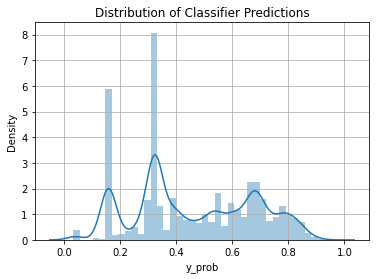

In [64]:
sns.distplot(res.y_prob);
plt.grid();
plt.title('Distribution of Classifier Predictions');

In [65]:
res_2 = pd.DataFrame(data={'importance': model.feature_importances_, 
                           'feature': X_test.columns}).sort_values('importance', ascending=False)

In [66]:
varr = X_train.var().reset_index()
varr.columns = ['feature', 'variance']

In [67]:
res_2 = pd.merge(res_2, varr, on='feature')

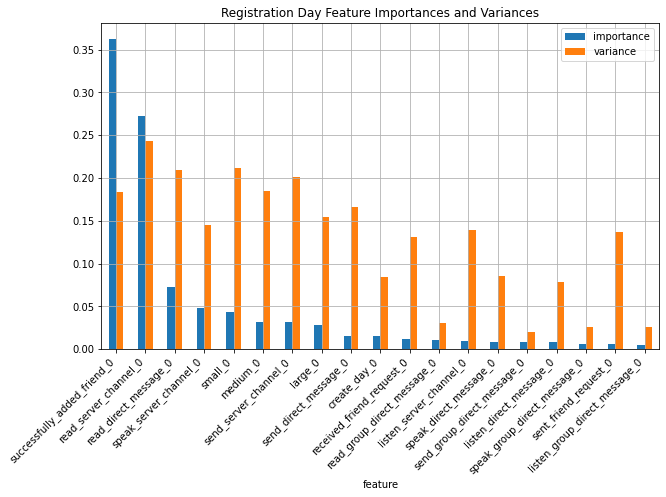

In [68]:
res_2.set_index('feature').plot(kind='bar', grid=True, figsize=(10, 6));
plt.title('Registration Day Feature Importances and Variances');
plt.xticks(rotation=45, ha='right');

In [72]:
dat_2 = dat.astype(bool).groupby(['small_0']).is_retained.value_counts().unstack(level=1)
dat_2['perc_retained'] = (dat_2[True] / (dat_2[False] + dat_2[True])).mul(100).round(2)

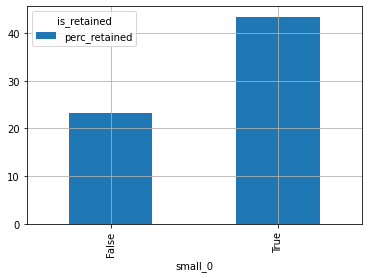

In [73]:
dat_2[['perc_retained']].plot(kind='bar', grid=True);